# PP5: deep learning intro

<a href="https://colab.research.google.com/github/PauliusU/PP5-deep-learning-intro/blob/master/PP5_deep_learning_intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Choosing and preparing the dataset

Project requires to use use dataset which suitable for non-linearly separable classification.

The famous [Iris flower dataset](https://en.wikipedia.org/wiki/Iris_flower_data_set) contains three classes, Setosa is linearly separable from the other two classes. Versicolor and Virginica classes are not linearly separable (see [source](https://www.researchgate.net/figure/Iris-data-set-There-are-three-classes-Setosa-class-is-linearly-separable-from-the-other_fig2_300643220)).

Therefore, the Iris dataset is suitable for the project.

In [107]:
# Load the dataset

from pprint import pprint
from sklearn.datasets import load_iris

# Initiate Iris flower dataset
dataset = load_iris()
pprint(dataset)


{'DESCR': '.. _iris_dataset:\n'
          '\n'
          'Iris plants dataset\n'
          '--------------------\n'
          '\n'
          '**Data Set Characteristics:**\n'
          '\n'
          '    :Number of Instances: 150 (50 in each of three classes)\n'
          '    :Number of Attributes: 4 numeric, predictive attributes and the '
          'class\n'
          '    :Attribute Information:\n'
          '        - sepal length in cm\n'
          '        - sepal width in cm\n'
          '        - petal length in cm\n'
          '        - petal width in cm\n'
          '        - class:\n'
          '                - Iris-Setosa\n'
          '                - Iris-Versicolour\n'
          '                - Iris-Virginica\n'
          '                \n'
          '    :Summary Statistics:\n'
          '\n'
          '    ============== ==== ==== ======= ===== ====================\n'
          '                    Min  Max   Mean    SD   Class Correlation\n'
          '  

In [108]:
# import pandas as pd

# # Initiate pandas DataFrame with first 4 attributes
# df = pd.DataFrame(dataset["data"], columns=[
#                   "setal length", "setal width", "petal length", "petal width"])
# # Add last (5th) attribute
# df["species"] = dataset["target"]
# df["species"] = df["species"].apply(lambda x: dataset["target_names"][x])
# # Remove rows containing linear "setosa" species
# df = df.drop(df[df.species == 'setosa' ].index)
# # Reindex
# df.reset_index(drop=True, inplace=True)

# # Get basic info about DataFrame
# print(df.info)  # Concise summary of a DataFrame.
# print(df.shape)  # (150, 5)
# print(df.head())  # First 5 records
# print(df.describe())  # Descriptive statistics
# print(df.isnull().sum())
# print(df.groupby("species").size())  # Group sizes for each species (class)

In [109]:
# Split the dataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

X = iris['data']
y = iris['target']
names = iris['target_names']
feature_names = iris['feature_names']

print(X)
print(y)

# One hot encoding
enc = OneHotEncoder() # TODO check Keras
Y = enc.fit_transform(y[:, np.newaxis]).toarray()

# Scale data to have mean 0 and variance 1 
# which is importance for convergence of the neural network
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print(X_scaled)
print(len(X_scaled))

# Split the data set into training and testing  # TODO check Keras
X_train, X_test, Y_train, Y_test = train_test_split(
    X_scaled, Y, test_size=0.2, random_state=2)

# Split the data set into training and testing # TODO check PyTorch
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=2)

n_features = X.shape[1] # TODO check PyTorch
n_classes = Y.shape[1] # TODO check PyTorch

[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]
 [5.4 3.9 1.7 0.4]
 [4.6 3.4 1.4 0.3]
 [5.  3.4 1.5 0.2]
 [4.4 2.9 1.4 0.2]
 [4.9 3.1 1.5 0.1]
 [5.4 3.7 1.5 0.2]
 [4.8 3.4 1.6 0.2]
 [4.8 3.  1.4 0.1]
 [4.3 3.  1.1 0.1]
 [5.8 4.  1.2 0.2]
 [5.7 4.4 1.5 0.4]
 [5.4 3.9 1.3 0.4]
 [5.1 3.5 1.4 0.3]
 [5.7 3.8 1.7 0.3]
 [5.1 3.8 1.5 0.3]
 [5.4 3.4 1.7 0.2]
 [5.1 3.7 1.5 0.4]
 [4.6 3.6 1.  0.2]
 [5.1 3.3 1.7 0.5]
 [4.8 3.4 1.9 0.2]
 [5.  3.  1.6 0.2]
 [5.  3.4 1.6 0.4]
 [5.2 3.5 1.5 0.2]
 [5.2 3.4 1.4 0.2]
 [4.7 3.2 1.6 0.2]
 [4.8 3.1 1.6 0.2]
 [5.4 3.4 1.5 0.4]
 [5.2 4.1 1.5 0.1]
 [5.5 4.2 1.4 0.2]
 [4.9 3.1 1.5 0.2]
 [5.  3.2 1.2 0.2]
 [5.5 3.5 1.3 0.2]
 [4.9 3.6 1.4 0.1]
 [4.4 3.  1.3 0.2]
 [5.1 3.4 1.5 0.2]
 [5.  3.5 1.3 0.3]
 [4.5 2.3 1.3 0.3]
 [4.4 3.2 1.3 0.2]
 [5.  3.5 1.6 0.6]
 [5.1 3.8 1.9 0.4]
 [4.8 3.  1.4 0.3]
 [5.1 3.8 1.6 0.2]
 [4.6 3.2 1.4 0.2]
 [5.3 3.7 1.5 0.2]
 [5.  3.3 1.4 0.2]
 [7.  3.2 4.7 1.4]
 [6.4 3.2 4.5 1.5]
 [6.9 3.1 4.

In [110]:
# # Before implementing any model we need to split the dataset to train and test sets

# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder

# # Split the data into X and y
# X = df.iloc[:,0:4].values
# y = df.iloc[:,4].values

# # Verify splitting
# print(X.shape) # (100, 4)
# print(y.shape) # (100,)

# # Convert target into LabelEncoder
# # Encode target labels with value between 0 and n_classes-1.
# # This transformer should be used to encode target values, i.e. y, and not the input X.
# encoder =  LabelEncoder()
# y1 = encoder.fit_transform(y) # Fit label encoder and return encoded labels.
# print(y1)

# # Convert X and Y into train and test data
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# # Verify splitting again
# print(X_train[0:3])
# print(X_test[0:3])
# print(y_train[0:3])
# print(y_test[0:3])

# # # Split the dataset to 70% as train and 30% as test datasets
# # train, test = train_test_split(df, test_size=0.3)

# # # Verify splitting results
# # print(train.shape)  # (105, 5)
# # print(test.shape)  # (45, 5)

# # # Split the train and test sets further as input and output sets
# # train_X = train[["setal length", "setal width", "petal length", "petal width"]]
# # train_y = train.species
# # test_X = test[["setal length", "setal width", "petal length", "petal width"]]
# # test_y = test.species

# # # Verify splitting results again
# # print(train_X.shape)
# # print(train_y.shape)
# # print(test_X.shape)
# # print(test_y.shape)

## Visualization

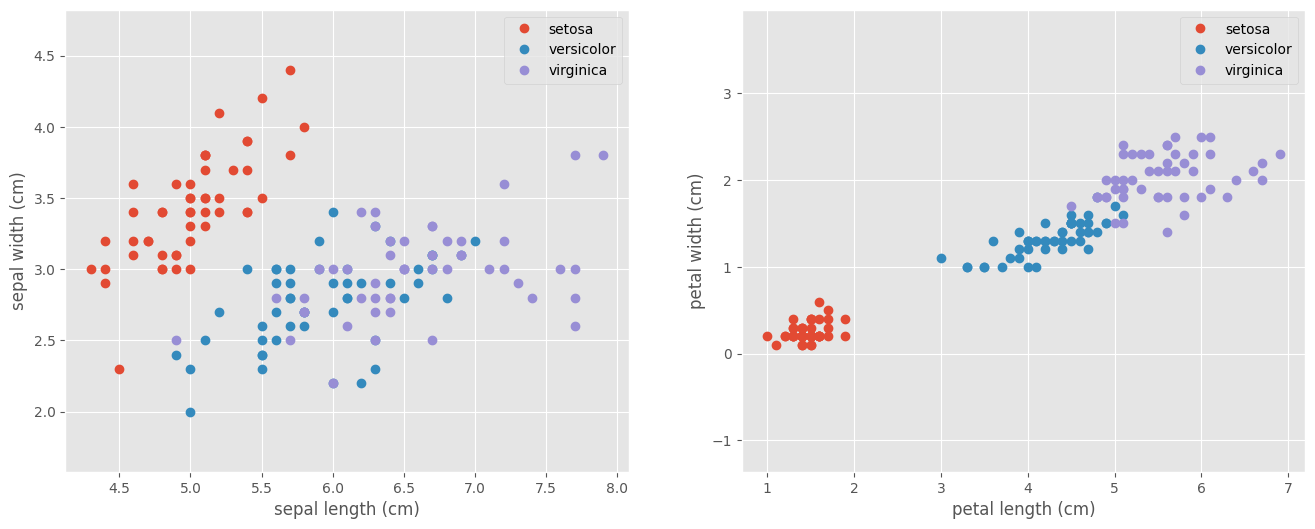

In [111]:
import matplotlib.pyplot as plt


# Visualize the data sets
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
for target, target_name in enumerate(names):
    X_plot = X[y == target]
    plt.plot(X_plot[:, 0], X_plot[:, 1], linestyle='none', marker='o', label=target_name)
plt.xlabel(feature_names[0])
plt.ylabel(feature_names[1])
plt.axis('equal')
plt.legend();

plt.subplot(1, 2, 2)
for target, target_name in enumerate(names):
    X_plot = X[y == target]
    plt.plot(X_plot[:, 2], X_plot[:, 3], linestyle='none', marker='o', label=target_name)
plt.xlabel(feature_names[2])
plt.ylabel(feature_names[3])
plt.axis('equal')
plt.legend();

## Keras

In [112]:
# In order to ignore FutureWarning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

from keras.models import Sequential
from keras.layers import Dense

def create_custom_model(input_dim, output_dim, nodes, n=1, name='model'):
    def create_model():
        # Create model
        model = Sequential(name=name)
        for i in range(n):
            model.add(Dense(nodes, input_dim=input_dim, activation='relu'))
        model.add(Dense(output_dim, activation='softmax'))

        # Compile model
        model.compile(loss='categorical_crossentropy', 
                      optimizer='adam', 
                      metrics=['accuracy'])
        return model
    return create_model

models = [create_custom_model(n_features, n_classes, 8, i, 'model_{}'.format(i)) 
          for i in range(1, 4)]

for create_model in models:
    create_model().summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_151 (Dense)           (None, 8)                 40        
                                                                 
 dense_152 (Dense)           (None, 3)                 27        
                                                                 
Total params: 67
Trainable params: 67
Non-trainable params: 0
_________________________________________________________________
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_153 (Dense)           (None, 8)                 40        
                                                                 
 dense_154 (Dense)           (None, 8)                 72        
                                                                 
 dense_155 (Dense)           (None, 3)        

In [113]:
from keras.callbacks import TensorBoard

history_dict = {}

# TensorBoard Callback
cb = TensorBoard()

for create_model in models:
    model = create_model()
    print('Model name:', model.name)
    history_callback = model.fit(X_train, Y_train,
                                 batch_size=5,
                                 epochs=50,
                                 verbose=0,
                                 validation_data=(X_test, Y_test),
                                 callbacks=[cb])
    score = model.evaluate(X_test, Y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    
    history_dict[model.name] = [history_callback, model]

Model name: model_1
Test loss: 0.18702074885368347
Test accuracy: 0.9333333373069763
Model name: model_2
Test loss: 0.11038246005773544
Test accuracy: 0.9666666388511658
Model name: model_3
Test loss: 0.18903371691703796
Test accuracy: 0.8999999761581421


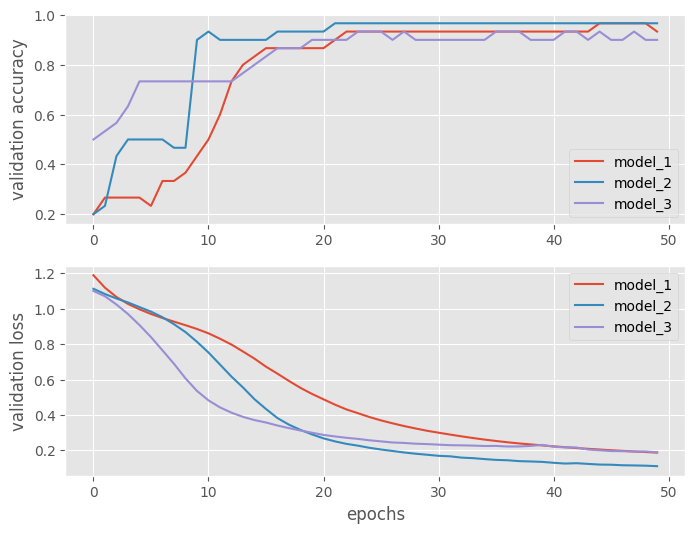

In [114]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(8, 6))

for model_name in history_dict:
    val_accurady = history_dict[model_name][0].history['val_accuracy']
    val_loss = history_dict[model_name][0].history['val_loss']
    ax1.plot(val_accurady, label=model_name)
    ax2.plot(val_loss, label=model_name)
    
ax1.set_ylabel('validation accuracy')
ax2.set_ylabel('validation loss')
ax2.set_xlabel('epochs')
ax1.legend()
ax2.legend();

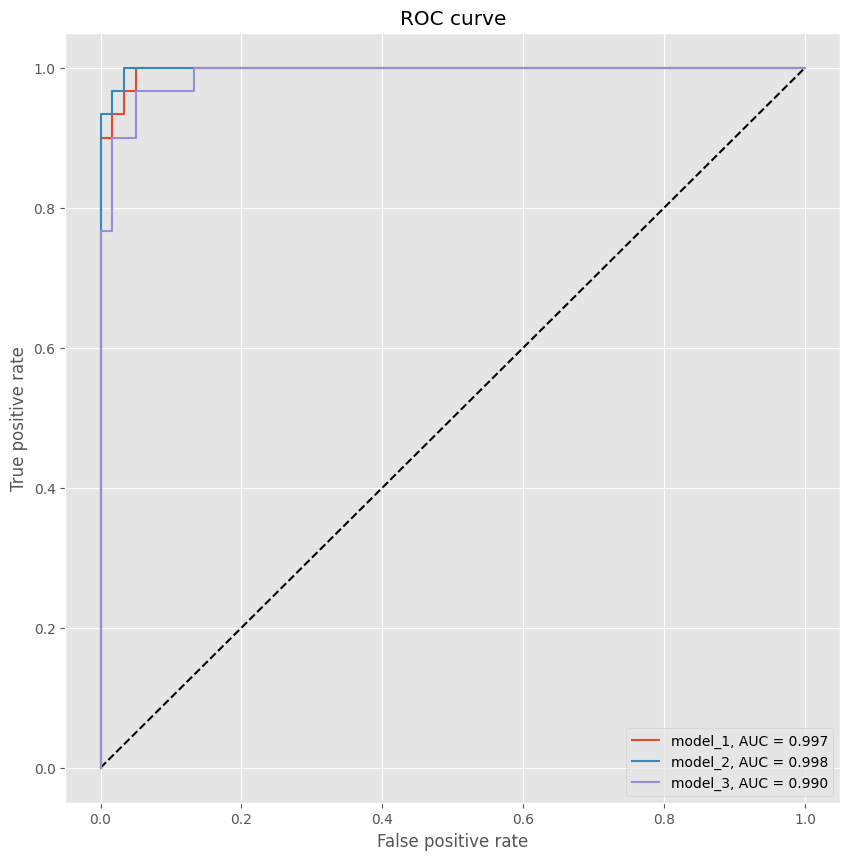

In [115]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(10, 10))
plt.plot([0, 1], [0, 1], 'k--')

for model_name in history_dict:
    model = history_dict[model_name][1]
    
    Y_pred = model.predict(X_test)
    fpr, tpr, threshold = roc_curve(Y_test.ravel(), Y_pred.ravel())
    
    plt.plot(fpr, tpr, label='{}, AUC = {:.3f}'.format(model_name, auc(fpr, tpr)))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend();

In [116]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score

create_model = create_custom_model(n_features, n_classes, 8, 3)

estimator = KerasClassifier(build_fn=create_model, epochs=100, batch_size=5, verbose=0)
scores = cross_val_score(estimator, X_scaled, Y, cv=10)
print(f"Accuracy : {scores.mean():0.2f} (+/- {scores.std():0.2f})")

Accuracy : 0.94 (+/- 0.08)


## PyTorch

In [117]:
import torch
print(torch.__version__)
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable

1.12.1+cpu


In [118]:
class Model(nn.Module):
    def __init__(self, input_dim):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(input_dim, 50)
        self.layer2 = nn.Linear(50, 50)
        self.layer3 = nn.Linear(50, 3)
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.softmax(self.layer3(x), dim=1)
        return x

In [119]:
model     = Model(X_train.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn   = nn.CrossEntropyLoss()
print(model)

Model(
  (layer1): Linear(in_features=4, out_features=50, bias=True)
  (layer2): Linear(in_features=50, out_features=50, bias=True)
  (layer3): Linear(in_features=50, out_features=3, bias=True)
)


In [120]:
import tqdm

EPOCHS  = 300
X_train = Variable(torch.from_numpy(X_train)).float()
y_train = Variable(torch.from_numpy(y_train)).long()
X_test  = Variable(torch.from_numpy(X_test)).float()
y_test  = Variable(torch.from_numpy(y_test)).long()

loss_list     = np.zeros((EPOCHS,))
accuracy_list = np.zeros((EPOCHS,))

for epoch in tqdm.trange(EPOCHS):
    y_pred = model(X_train)
    loss = loss_fn(y_pred, y_train)
    loss_list[epoch] = loss.item()
    
    # Zero gradients
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        y_pred = model(X_test)
        correct = (torch.argmax(y_pred, dim=1) == y_test).type(torch.FloatTensor)
        accuracy_list[epoch] = correct.mean()

100%|██████████| 300/300 [00:00<00:00, 480.06it/s]


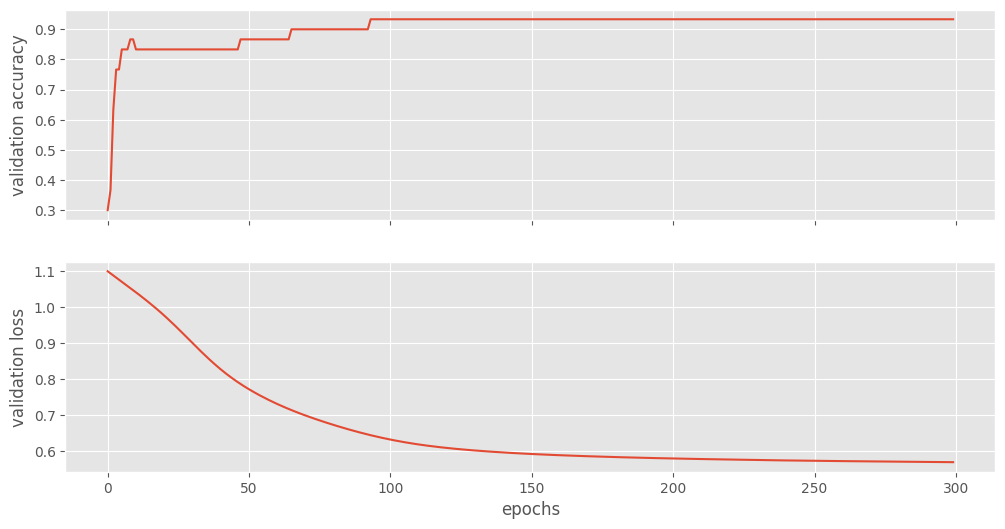

In [121]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)

ax1.plot(accuracy_list)
ax1.set_ylabel("validation accuracy")
ax2.plot(loss_list)
ax2.set_ylabel("validation loss")
ax2.set_xlabel("epochs");

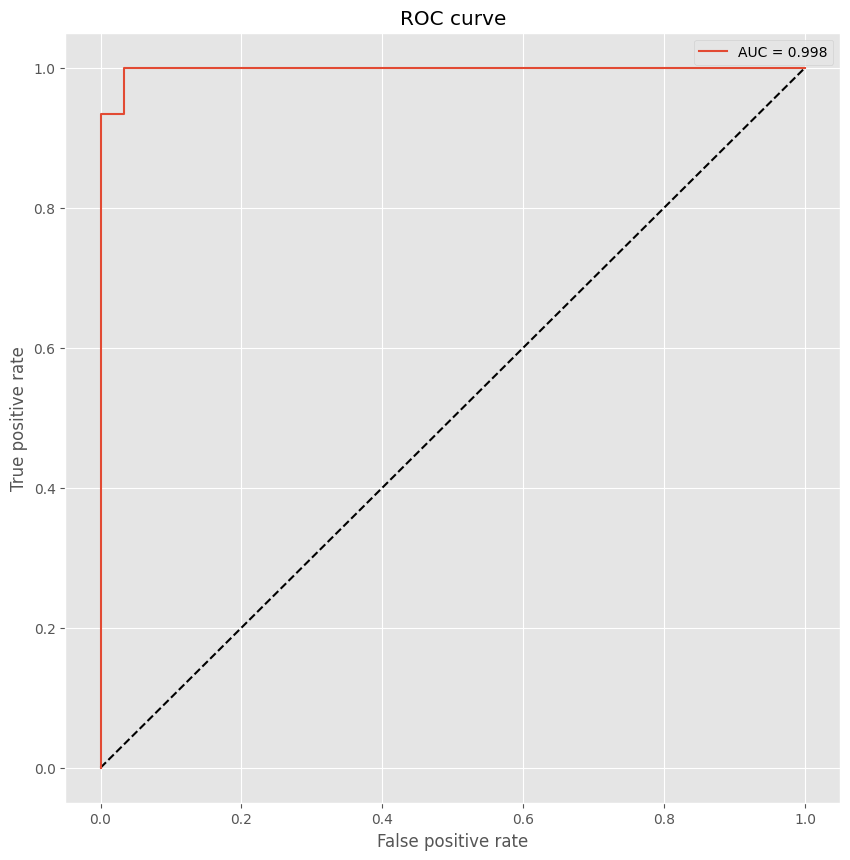

In [122]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import OneHotEncoder

plt.figure(figsize=(10, 10))
plt.plot([0, 1], [0, 1], 'k--')

# One hot encoding
enc = OneHotEncoder()
Y_onehot = enc.fit_transform(y_test[:, np.newaxis]).toarray()

with torch.no_grad():
    y_pred = model(X_test).numpy()
    fpr, tpr, threshold = roc_curve(Y_onehot.ravel(), y_pred.ravel())
    
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc(fpr, tpr)))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend();